# Background
- **Author**: `<郭伊軒>`
- **Created At**: `<2025-10-26>`
- **Path to Training Data： extent-of-discount-rate-DE.csv** 
- **Path to Testing Data： extent-of-discount-rate-DE.csv** 
- **Model Specification**
    - Method： XGBoost regression
    - Variables：  
    Dependent Variable (y): DiscountRate  
    Independent Variables (X): ["Age", "AccumulatedPositiveRate", "SalePeriod", "PlayerGrowthRate1W", "PlayerGrowthRate2W", "PlayerGrowthRate1M", "FollowersGrowthRate1W", "FollowersGrowthRate2W", "FollowersGrowthRate1M", "PositiveRateGrowthRate1W", "PositiveRateGrowthRate2W", "PositiveRateGrowthRate1M", "DLC_since_last_discount", "Sequel_since_last_discount"]
    - Tuning Parameters：  
    random_state = 71  
    test_size = 0.2                        
    - Optimization Method：XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=3, learning_rate=0.3) wuth one week data
- **Main Findings and Takeaways：**
    - In-sample `<R², RMSE>`:  
    1w(0.985, 0.023)、2w(0.952, 0.041)、1m(0.964, 0.035)
    - Out-sample `<R², RMSE>`:  
    1w(0.719, 0.095)、2w(0.690, 0.099)、1m(0.643, 0.107)
- **Future Direciton：**

In [ ]:
# Load packages here
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
input_data_file = "/Users/10610/Desktop/114-1 資料/steam-project/extent-of-discount-rate-DE.csv"
data = pd.read_csv(input_data_file)

In [5]:
data.head()

,Date,GameID,Type,MultiPlayer,Publisher,ConstantDiscount,DiscountRate,Age,AccumulatedPositiveRate,SalePeriod,...,PlayerGrowthRate2W,PlayerGrowthRate1M,FollowersGrowthRate1W,FollowersGrowthRate2W,FollowersGrowthRate1M,PositiveRateGrowthRate1W,PositiveRateGrowthRate2W,PositiveRateGrowthRate1M,DLC_since_last_discount,Sequel_since_last_discount
0,2023-06-29,10,Action,1,Valve,0,0.903226,22.671233,0.975168,1,...,-0.033624,-0.037584,0.000673,0.001362,0.003116,0.000053,0.000015,0.000023,0,0
1,2023-09-12,10,Action,1,Valve,0,0.903226,22.876712,0.974990,0,...,0.022963,0.003837,0.000553,0.001087,0.002301,0.000004,0.000031,-0.000026,0,0
2,2023-09-15,10,Action,1,Valve,0,0.897849,22.884932,0.974926,0,...,0.021006,0.013577,0.001878,0.002493,0.003623,-0.000068,-0.000035,-0.000072,0,0
3,2023-11-21,10,Action,1,Valve,0,0.903226,23.068493,0.974686,1,...,-0.039165,0.015256,0.001381,0.002082,0.004059,-0.000146,-0.000165,-0.000152,0,0
4,2023-12-21,10,Action,1,Valve,0,0.897849,23.150685,0.974675,1,...,-0.033895,-0.006214,0.000790,0.001743,0.004781,0.000016,0.000014,-0.000011,0,0


### The actual modeling starts below
For the remaining blocks, make sure you have followed the guidelines as specified in [專案資料夾結構、檔案命名與文件規範](https://docs.google.com/document/d/1sl6gEFMdmiGsiNjLe17UmZ30xKxq15U0Mb2B-Jvusxg/edit?tab=t.33iie8ybx7s4).


In [9]:

def find_best_params(X,y):
    ratiovalue = 20
    objective = ["reg:squarederror", "reg:squaredlogerror"]
    n_estimatorvalues = [i for i in range(100, 250, 50)]
    depthvalues = [i for i in range(1, 8)]
    ratevalues = [i/10 for i in range(1, 4)]

    best_train_r2 = -float('inf')
    best_test_r2 = -float('inf')
    best_params = {}

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratiovalue/100, random_state=71)
    for k in objective:
        for l in n_estimatorvalues:
            for i in depthvalues:
                for j in ratevalues:
                    clf = XGBRegressor(random_state=71, objective=k, n_estimators=l, max_depth=i, learning_rate=j)
                    clf.fit(X_train, y_train)

                    y_pred_train = clf.predict(X_train)
                    y_pred_test = clf.predict(X_test)

                    train_r2 = r2_score(y_train, y_pred_train)
                    test_r2 = r2_score(y_test, y_pred_test)
                    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
                    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
                    # 如果測試 R² 更高，就更新最佳組合
                    if test_r2 > best_test_r2:
                        best_test_r2 = test_r2
                        best_train_r2 = train_r2
                        best_params = {
                            "train_r2": train_r2,
                            "test_r2": test_r2,
                            "train_rmse": train_rmse,
                            "test_rmse": test_rmse,
                            "objective": k,
                            "n_estimators": l,
                            "max_depth": i,
                            "learning_rate": j
                        }
    print("best objective:" , best_params["objective"], "\nbest no. of estimators:", best_params["n_estimators"], 
          "\nbest depth:", best_params["max_depth"], "\nbest learning_rate:", best_params["learning_rate"],
          "\nTraining r2:", best_params["train_r2"], "\nTesting r2:", best_params["test_r2"], "\ntrain_rmse:", best_params["train_rmse"], "\ntest_rmse:", best_params["test_rmse"])


In [16]:
variables_1w = ["Age", "AccumulatedPositiveRate", "SalePeriod", 
               "PlayerGrowthRate1W", "FollowersGrowthRate1W", "PositiveRateGrowthRate1W", 
               "DLC_since_last_discount", "Sequel_since_last_discount"]
x_1w = data[variables_1w]
y_1w = data["DiscountRate"]
find_best_params(x_1w,y_1w)


best objective: reg:squaredlogerror 
best no. of estimators: 200 
best depth: 4 
best learning_rate: 0.1 
Training r2: 0.9751921529133315 
Testing r2: 0.6931865321513191 
train_rmse: 0.029106535412659444 
test_rmse: 0.10323663245740466


                      Feature  Importance
0                         Age       562.0
1     AccumulatedPositiveRate       487.0
3          PlayerGrowthRate1W       358.0
4       FollowersGrowthRate1W       349.0
5    PositiveRateGrowthRate1W       333.0
2                  SalePeriod        46.0
7  Sequel_since_last_discount        15.0
6     DLC_since_last_discount         2.0


<Figure size 800x600 with 0 Axes>

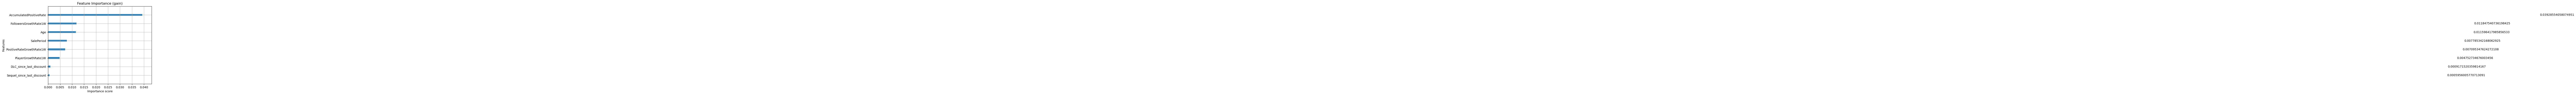

In [15]:
clf = XGBRegressor(random_state=71, objective='reg:squaredlogerror', n_estimators=200, max_depth=4, learning_rate=0.1)
clf.fit(x_1w, y_1w)
importance = clf.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# 畫出重要性圖
plt.figure(figsize=(8,6))
plot_importance(clf, importance_type='gain')
plt.title("Feature Importance (gain)")
plt.show()

In [12]:
variables_2w = ["Age", "AccumulatedPositiveRate", "SalePeriod", 
               "PlayerGrowthRate2W", "FollowersGrowthRate2W", "PositiveRateGrowthRate2W", 
               "DLC_since_last_discount", "Sequel_since_last_discount"]
x_2w = data[variables_2w]
y_2w = data["DiscountRate"]
find_best_params(x_2w,y_2w)

best objective: reg:squaredlogerror 
best no. of estimators: 100 
best depth: 3 
best learning_rate: 0.2 
Training r2: 0.9516231228059869 
Testing r2: 0.689761220166564 
train_rmse: 0.040667071734494714 
test_rmse: 0.09939244246100871


In [13]:
variables_1m = ["Age", "AccumulatedPositiveRate", "SalePeriod", 
               "PlayerGrowthRate1M", "FollowersGrowthRate1M", "PositiveRateGrowthRate1M", 
               "DLC_since_last_discount", "Sequel_since_last_discount"]
x_1m = data[variables_1m]
y_1m = data["DiscountRate"]
find_best_params(x_1m,y_1m)

best objective: reg:squarederror 
best no. of estimators: 100 
best depth: 4 
best learning_rate: 0.1 
Training r2: 0.9643532638348449 
Testing r2: 0.6427283311177591 
train_rmse: 0.03490871578987232 
test_rmse: 0.10666074444536779
